# TSFEL predicting Normal Vs. Pathological knee

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists of importing TSFEL library. To do so press play. 

The import can take few seconds, but the run button will change so that you know that the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

In [4]:
# @title Import Time Series Feature Extraction Library
import warnings

warnings.filterwarnings("ignore")
!pip install tsfel >/dev/null 2>&1
!pip install patool >/dev/null 2>&1
from sys import platform

if platform == "linux" or platform == "linux2":
    !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar >/dev/null 2>&1
else:
    !pip install wget >/dev/null 2>&1
    import wget

    wget.download("http://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar")

In [8]:
# Import libraries
import glob
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patoolib
import scipy.interpolate as interp
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

import tsfel

## Auxiliary Methods

**Data pre-processing**

Method to interpolate each file data (EMG and goniometer signals) to the same sample size.

In [38]:
def preprocess(data):
    """Interpolating the EMG and goniometer to the same sample size

    Parameters
    ----------
    data list of pandas DataFrame
      EMG and gonomioter signals for a given activity
    Returns
    -------
      Interpolated data (list of nd-array)

    """
    data = [
        interp.interp1d(np.arange(len(x[0].dropna())), x[0].dropna(), axis=0, kind="nearest")(
            np.linspace(0, len(x[0].dropna()) - 1, len(x[0].iloc[:, 0].dropna()))
        )
        for x in data
    ]
    return data

## Dataset

The dataset was acquired by Batallón de sanidad (BASAN) in collaboration with the Universidad Militar Nueva Granada – Bogotá. The protocol was performed by 22 male subjects, 11 with different knee abnormalities previously diagnosed by a professional and other 11 without any known knee pathology. The participants were required to perform 3 different exercises: (1) **walk**, (2) **extension of the leg from the sit position** and (3) **flexion of the knee stand up**.

The acquisition process was conducted with 4 electrodes placed on the following muscles (vastus internus, semitendinosus, biceps femoris and rectus femoris) and a goniometer in the knee.

 
**For this example, we will only be using files from the (2) activity and data from rectus femoris muscle and from the goniometer sensor. The classifier will predict if the participant has a normal or pathological knee.**

In [50]:
# @title Loading normal and pathological files from extension of the leg from the sit position
normal_files = glob.glob("N_TXT/*.txt")
patholo_files = glob.glob("A_TXT/*.txt")

normalfl = [
    [pd.read_csv(fl, sep="\t", skiprows=7, usecols=(0, 4), header=None).dropna()] for fl in normal_files if "Npie" in fl
]

patholofl = [
    [pd.read_csv(fl, sep="\t", skiprows=7, usecols=(0, 4), header=None).dropna()]
    for fl in patholo_files
    if "Apie" in fl
]

In [51]:
normalfl

[[           0     4
  0    -0.0008  10.2
  1    -0.0008  10.2
  2    -0.0015  10.2
  3    -0.0015  10.2
  4    -0.0008  10.2
  ...      ...   ...
  9534  0.0037   5.7
  9535  0.0105   5.5
  9536  0.0157   5.3
  9537  0.0135   5.2
  9538  0.0060   5.0
  
  [9539 rows x 2 columns]],
 [            0     4
  0      0.0015   3.0
  1      0.0030   3.0
  2      0.0037   3.0
  3      0.0000   3.0
  4     -0.0008   3.0
  ...       ...   ...
  14515 -0.0060  10.1
  14516 -0.0060  10.1
  14517 -0.0060  10.1
  14518 -0.0060  10.1
  14519 -0.0060  10.1
  
  [14520 rows x 2 columns]],
 [            0     4
  0     -0.0030   5.7
  1      0.0037   5.8
  2      0.0045   5.9
  3      0.0015   5.8
  4      0.0015   6.1
  ...       ...   ...
  10654 -0.0008  16.2
  10655 -0.0008  16.4
  10656 -0.0030  16.3
  10657 -0.0053  16.4
  10658 -0.0030  16.3
  
  [10659 rows x 2 columns]],
 [            0    4
  0      0.0045  2.6
  1      0.0142  2.6
  2      0.0165  2.6
  3      0.0165  2.6
  4      0.0180  2.6

In [ ]:
# @title Train and test set
# dataset sampling frequency, according to dataset information
fs = 1000
# window size for window splitter method (each window has 1 seconds)
window_size = 1000

# Interpolating data
normalfl = preprocess(normalfl)
patholofl = preprocess(patholofl)

# Dividing into train and test sets. Splitting signal in windows
# Using 2 normal files and 2 pathological files for test set
x_train = list(
    itertools.chain(
        *[
            tsfel.signal_window_splitter(signal[i], window_size, overlap=0)
            for signal in [normalfl, patholofl]
            for i in range(len(normalfl) - 2)
        ]
    )
)
x_test = list(
    itertools.chain(
        *[
            tsfel.signal_window_splitter(signal[i], window_size, overlap=0)
            for signal in [normalfl, patholofl]
            for i in [len(normalfl) - 2, len(normalfl) - 1]
        ]
    )
)

y_train = np.concatenate(
    (
        np.repeat(
            0,
            np.cumsum([int(len(normalfl[i]) / window_size) for i in range(len(normalfl) - 2)])[-1],
        ),
        np.repeat(
            1,
            np.cumsum([int(len(patholofl[i]) / window_size) for i in range(len(patholofl) - 2)])[-1],
        ),
    )
)

y_test = np.concatenate(
    (
        np.repeat(
            0,
            np.cumsum([int(len(normalfl[i]) / window_size) for i in [len(normalfl) - 2, len(normalfl) - 1]])[-1],
        ),
        np.repeat(
            1,
            np.cumsum([int(len(patholofl[i]) / window_size) for i in [len(patholofl) - 2, len(patholofl) - 1]])[-1],
        ),
    )
)

In [52]:
x_train[0].shape

(1000, 2)

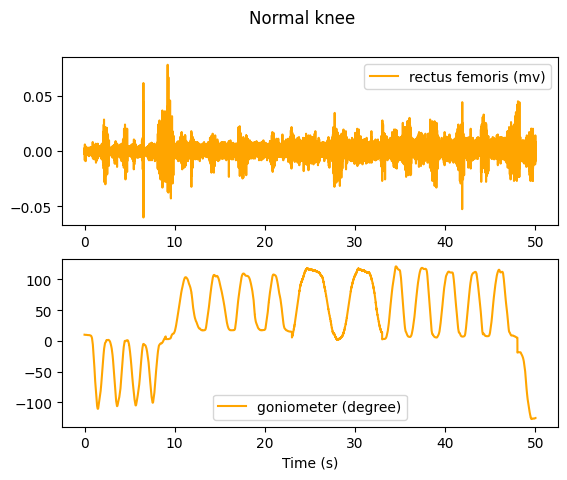

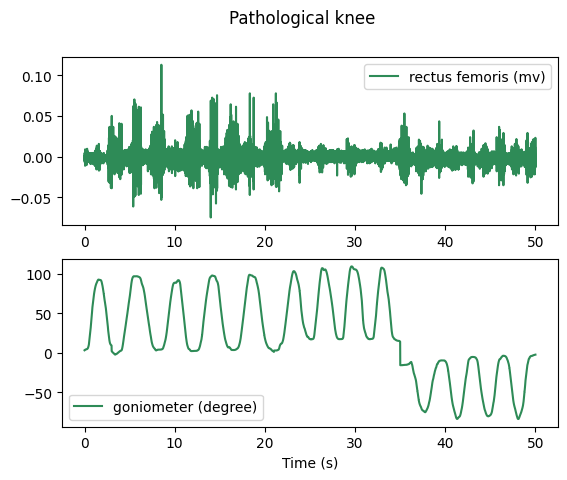

In [48]:
# @title Visualizing signals
nsignal = np.concatenate(x_train[:50])
asignal = np.concatenate(x_train[-50:])
time = np.linspace(0, len(nsignal) * 1 / fs, len(nsignal))
c = ["orange", "seagreen"]
title = ["Normal knee", "Pathological knee"]

for i, signal in enumerate([nsignal, asignal]):
    plt.figure(i)
    plt.subplot(211)
    plt.plot(time, signal[:, 0], color=c[i], label="rectus femoris (mv)")
    plt.legend()
    plt.subplot(212)
    plt.plot(time, signal[:, 1], color=c[i], label="goniometer (degree)")
    plt.legend()
    plt.suptitle(title[i])

    plt.xlabel("Time (s)")

# Feature Extraction

In [28]:
# Extract all features' domains (spectral, statistical and temporal)
cfg_file = tsfel.get_features_by_domain()
X_train = tsfel.time_series_features_extractor(cfg_file, x_train, fs=fs, header_names=np.array(["emg", "gon"]))
X_test = tsfel.time_series_features_extractor(cfg_file, x_test, fs=fs, header_names=np.array(["emg", "gon"]))

In [29]:
X_train.shape

(322, 312)

# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [ ]:
# Highly correlated features are removed
corr_features, X_train = tsfel.correlated_features(X_train, drop_correlated=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(X_train)
nX_test = scaler.transform(X_test)

# Classification

In this example the classification is performed with a [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) classifier.

In [ ]:
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(nX_train, y_train.ravel())

# Predict on test data
y_predict = classifier.predict(nX_test)

condition_labels = ["Normal", "Pathological"]

# Get the classification report
accuracy = accuracy_score(y_test, y_predict) * 100
print(classification_report(y_test, y_predict, target_names=condition_labels))
print("Accuracy: " + str(accuracy) + "%")

In [ ]:
# @title Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=[i for i in condition_labels], columns=[i for i in condition_labels])
plt.figure()
ax = sns.heatmap(df_cm, cbar=True, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.ylabel("True label", fontweight="bold", fontsize=18)
plt.xlabel("Predicted label", fontweight="bold", fontsize=18)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

All features domains were used in the feature extraction step. Accordingly, the Decision Tree classifier obtained high accuracy and was able to distinguish between normal and pathological knee condition during the extension of the leg from the sit position activity.